In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection

In [2]:
def ecdf(data):
    plt.plot(np.sort(data), np.linspace(0,1,len(data)))

## Data loading

In [3]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [4]:
train_o.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,1,6,14,6,6,1,1,10,2,1
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,6,11,1,6,1,4,4,1,13,0
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,4,21,12,1,16,10,4,9,0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,13,12,2,4,2,7,1,2,11,1
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,12,2,2,4,1,3,1,11,15,1


In [5]:
def fillize(data):
    """Replace NaNs with zero, and adds indicator
    *only checks opened_position_qty"""
    nans = np.isnan(data["opened_position_qty"])
    return data.fillna(0).assign(nans=nans)

def deidize(data):
    """drop id column"""
    return data.drop("id", axis=1)

def relize(data):
    """replace bid[i] and ask[i] columns with
    bid[i]-bid[i-1] ans ask[i]-ask[i-1]"""
    rel = data.copy()
    for i in range(5,1,-1):
        rel[f"bid{i}"] -= rel[f"bid{i-1}"]
        rel[f"ask{i}"] -= rel[f"ask{i-1}"]

    rel["ask1"] -= rel["last_price"]
    rel["bid1"] -= rel["last_price"]
    return rel

def normize(train, test):
    """standardize last_price and mid"""
    mu = train["last_price"].mean()
    sigma = train["last_price"].std()
    ntrain = train.copy()
    ntrain.loc[:,["last_price", "mid"]] = (ntrain.loc[:,["last_price", "mid"]] - mu) / sigma
    if (test is not None):
        ntest = test.copy()
        ntest.loc[:,["last_price", "mid"]] = (ntest.loc[:,["last_price", "mid"]] - mu) / sigma
        return ntrain, ntest
    return ntrain

In [6]:
train = fillize(relize(deidize(train_o)))
test = fillize(relize(deidize(test_o)))
train, test = normize(train, test)

In [7]:
def splitize(data):
    """make train and validation set"""
    return sklearn.model_selection.train_test_split(data.drop("y",axis=1), data["y"])
trainX, valX, trainY, valY = splitize(train)

## Ridge

0.6439852038761934

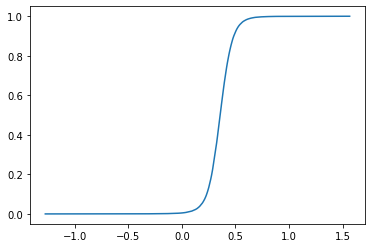

In [8]:
ridge = sklearn.linear_model.Ridge()
ridge.fit(trainX, trainY)
p = ridge.predict(valX)
ecdf(p)
sklearn.metrics.roc_auc_score(valY, p)

## Predict

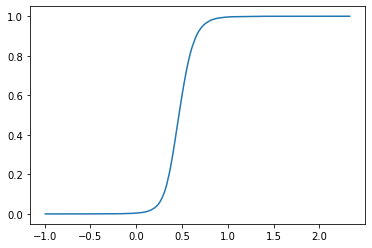

In [9]:
# fit on all data and predict
ridge = sklearn.linear_model.Ridge()
ridge.fit(train.drop("y",axis=1), train["y"])
p = ridge.predict(test)
ecdf(p)

In [10]:
# final output requires values in [0,1]
pscale = (p - np.min(p)) / (np.max(p)-np.min(p))
out = pd.DataFrame({"id":test_o.iloc[:,0], "Predicted":pscale})

with open("stockrdige.csv", "w") as f:
    f.write(out.to_csv(index=False))